In [102]:
!pip install banglanltk bangla-stemmer

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
from bangla_stemmer.stemmer import stemmer
import time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,log_loss,jaccard_score,roc_auc_score,classification_report,confusion_matrix
from torch.utils.data import Dataset, DataLoader

# **Train Dataset Loading**

In [104]:
import os

print(os.listdir('/kaggle/input/revolution-24'))


['AUG_Revolt_24 - Sheet1.xlsx']


In [105]:
# Read the xlxs file into a DataFrame

train_data  = pd.read_excel("/kaggle/input/revolution-24/AUG_Revolt_24 - Sheet1.xlsx")
stopwords_df = pd.read_excel('/kaggle/input/stopwords/stopwords_bangla.xlsx')
# Display the DataFrame
train_data.head()

,date,Headline,Sentiment
0,2024-07-05,ঢাকা বিশ্ববিদ্যালয়: কোটাবিরোধী আন্দোলনের নেতাক...,outrage
1,2024-07-05,কোটাবিরোধী আন্দোলনে ঢাকা বিশ্ববিদ্যালয়ের বিএনপ...,hope
2,2024-07-05,কোটাবিরোধী আন্দোলন : আজও জিরো পয়েন্ট অবরোধ করে...,outrage
3,2024-07-06,"সর্বজনীন পেনশন: সরকার অনড়, আন্দোলন চালিয়ে যাবে...",outrage
4,2024-07-06,আজ শনিবার সকাল সাড়ে ১০টার দিকে মহাসড়কের শহর বা...,outrage


In [106]:
# drop date
train_data = train_data.drop('date', axis=1)

In [107]:
label_counts = train_data['Sentiment'].value_counts()
label_counts

Sentiment
outrage    838
hope       838
despair    838
Name: count, dtype: int64

In [108]:
stopwords_df.head()

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ


In [109]:
import re

def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\u2600-\u26FF"          # miscellaneous symbols
                               u"\u2700-\u27BF"          # dingbats
                               u"\u2000-\u206F"          # general punctuations
                               "]+", flags=re.UNICODE)
    english_pattern = re.compile('[a-zA-Z]+', flags=re.I)

    text = emoji_pattern.sub(r'', text)
    text = english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct += char

    return no_punct

def preprocessing(text):
    text = replace_strings(text)
    text = remove_punctuations(text)
    return text

In [110]:
# prompt: for each Headline column of posts_df, apply the preprocessing function to each row

train_data['Headline'] =train_data['Headline'].apply(lambda x: preprocessing(str(x)))
train_data.head()

,Headline,Sentiment
0,ঢাকা বিশ্ববিদ্যালয় কোটাবিরোধী আন্দোলনের নেতাকে...,outrage
1,কোটাবিরোধী আন্দোলনে ঢাকা বিশ্ববিদ্যালয়ের বিএনপ...,hope
2,কোটাবিরোধী আন্দোলন আজও জিরো পয়েন্ট অবরোধ করে ...,outrage
3,সর্বজনীন পেনশন সরকার অনড় আন্দোলন চালিয়ে যাবেন ...,outrage
4,আজ শনিবার সকাল সাড়ে টার দিকে মহাসড়কের শহর বাইপ...,outrage


In [111]:
# Remove Stopwords
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stopwords_df]

    out=' '.join(stm)

    return str(out)

In [112]:
train_data['Headline'] =train_data['Headline'].apply(lambda x: stopwordRemoval(str(x)))
train_data.head()

,Headline,Sentiment
0,ঢাকা বিশ্ববিদ্যালয় কোটাবিরোধী আন্দোলনের নেতাকে...,outrage
1,কোটাবিরোধী আন্দোলনে ঢাকা বিশ্ববিদ্যালয়ের বিএনপ...,hope
2,কোটাবিরোধী আন্দোলন আজও জিরো পয়েন্ট অবরোধ করে খ...,outrage
3,সর্বজনীন পেনশন সরকার অনড় আন্দোলন চালিয়ে যাবেন ...,outrage
4,আজ শনিবার সকাল সাড়ে টার দিকে মহাসড়কের শহর বাইপ...,outrage


In [113]:
# stemmer function
def stem_text(x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [114]:
!pip install datasets pandas torch openpyxl banglanltk bangla-stemmer gensim pyLDAvis

In [115]:
train_data['Headline'] =train_data['Headline'].apply(lambda x: stem_text(str(x)))

applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..


In [118]:
#make test_data and val data_from train_data
train_data, val_data = train_test_split(train_data, test_size=0.3, random_state=42,stratify=train_data['Sentiment'])
# make test data from val data
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42,stratify=val_data['Sentiment'])

In [119]:
len(train_data)

1231

In [120]:
len(test_data)

264

In [121]:
len(val_data)

264

In [122]:
label_counts = train_data['Sentiment'].value_counts()
label_counts

Sentiment
despair    411
hope       410
outrage    410
Name: count, dtype: int64

# **Visualization of Label Distribution in Train Dataset**
  

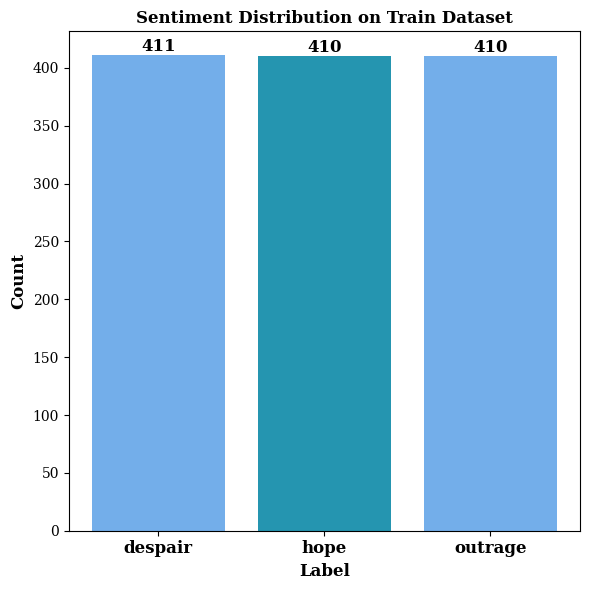

In [123]:
label_counts = train_data['Sentiment'].value_counts()

# Define custom colors for the bars
custom_colors = ['#73aeea', '#2595b0']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)


# Set title and axis labels using custom fontdict
plt.title('Sentiment Distribution on Train Dataset', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('Rev_train.pdf')  # Save as pdf format
plt.show()


# **Visualization of Label Distribution in Test Dataset**


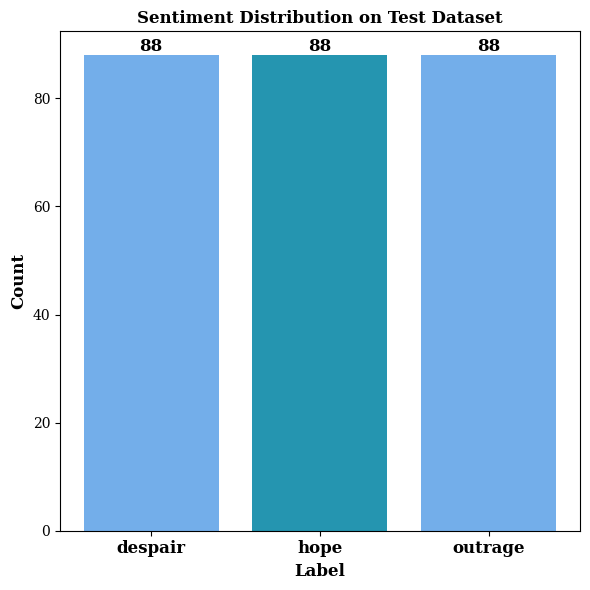

In [124]:
label_counts = test_data['Sentiment'].value_counts()

# Define custom colors for the bars
custom_colors = ['#73aeea', '#2595b0']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)


# Set title and axis labels using custom fontdict
plt.title('Sentiment Distribution on Test Dataset', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('test.pdf')  # Save as pdf format
plt.show()


# **Visualization of Label Distribution in Validation Dataset**


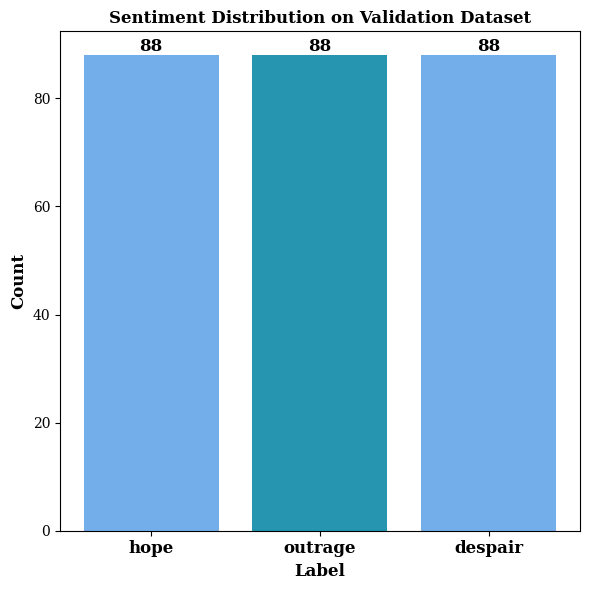

In [125]:
label_counts = val_data['Sentiment'].value_counts()

# Define custom colors for the bars
custom_colors = ['#73aeea', '#2595b0']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(6, 6))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)


# Set title and axis labels using custom fontdict
plt.title('Sentiment Distribution on Validation Dataset', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('validation.pdf')  # Save as pdf format
plt.show()


In [126]:
print(f"Length of train dataset: {len(train_data)}")
print(f"Length of test dataset: {len(test_data)}")
print(f"Length of validation dataset: {len(val_data)}")

Length of train dataset: 1231
Length of test dataset: 264
Length of validation dataset: 264


# **Custom Dataset Class**

In [127]:
class BanglaPoliticalSentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Define a mapping for sentiment labels
        self.sentiment_map = {"outrage": 0, "hope": 1,"despair":2}  # You can add more sentiments if needed

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        content = self.data.iloc[idx]['Headline']
        label = self.data.iloc[idx]['Sentiment']

        # Convert sentiment label to integer using the mapping
        label = self.sentiment_map[label]

        inputs = self.tokenizer.encode_plus(
            content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long) #torch.nn.CrossEntropyLoss expects the target labels to be torch.LongTensor.
        }


In [128]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-vuz2eyze
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-vuz2eyze
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done


In [129]:
!pip install transformers[sentencepiece]

In [130]:
!pip install torch

In [131]:
!pip install accelerate -U

# **xlm-roberta-base model and its tokenizer**

In [132]:
!pip install sympy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 62.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


In [133]:
pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 82.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
Note: you may need to restart the kernel to use updated packages.


In [134]:
pip install --upgrade torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 62.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
Note: you may need to restart the kernel to use updated packages.


In [135]:
pip install --upgrade pycparser


Note: you may need to restart the kernel to use updated packages.


In [136]:
# Model loading
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from normalizer import normalize # pip install git+https://github.com/csebuetnlp/normalizer
num_classes = 3  #number of classes in our dataset
from transformers import RobertaTokenizer
model_name = "FacebookAI/xlm-roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [137]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [138]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

# **Apply normalization to the datasets**

In [139]:
# Apply normalization to the datasets
train_data['Headline'] = train_data['Headline'].apply(normalize)
test_data['Headline'] = test_data['Headline'].apply(normalize)
val_data['Headline'] = val_data['Headline'].apply(normalize)

# **Custom dataset and dataloader**

In [140]:
# Define custom datasets
train_dataset = BanglaPoliticalSentimentDataset(train_data, tokenizer)
val_dataset = BanglaPoliticalSentimentDataset(val_data, tokenizer)
test_dataset = BanglaPoliticalSentimentDataset(test_data, tokenizer)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False)

# **Train Dataset Encoding Printing**

In [141]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


#     # Break out of the loop after processing the first batch
    break


Input IDs: tensor([     0,      6,  65467,   2784, 126870,  24845, 114715, 230883,  20275,
          4822,      2,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      

# **Test Dataset Encoding Printing**

In [142]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([     0,  57732,  30511,  81474,  13504,  68927,      6, 219155,   4979,
          9853, 166101,   4691, 141001,   4480,      2,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      

# **Validation Dataset Encoding Printing**

In [143]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([     0,      6,  24373,  46234,  18780, 132133, 206207, 153634,      6,
        224623,   4691,  17455,  21296,  75880, 200706,   8339,  98282,  52553,
         47835, 216907,  89783,  19293,  86822, 142303,  52553,  57523,  34483,
          3718, 239322,    956, 208928,  48285,  22741,   5780,   2784,  16209,
        126612,  23304,  37555,  11291,  22349,    956, 113893,  17830,  11291,
             2,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      

# **Train Dataset Decoding Printing**

In [144]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


Decoded Input Text: বাড় কারফিউ শিথিল সময় জনমনে আস স্বস্তি
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# **Test Dataset Decoding Printing**

In [145]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


Decoded Input Text: সেই সব হত্যাকাণ্ড দৃশ্য আমা ঘুমা দেয় না
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# **Validation Dataset Decoding Printing**

In [146]:
# Set a flag to track whether it's the first batch
first_batch = True

# Iterate through the DataLoader
for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]

    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = labels.item()  # Assuming labels are single integers
    print("Label:", decoded_labels)

    # Break out of the loop after processing the first sample from the first batch
    break


Decoded Input Text: পুরান ঢাকা সদরঘাট এলাকায় চাঁদাবাজি কর অভিযোগে এক ব্যক্তি আটক করেছেন জগন্নাথ বিশ্ববিদ্যালয় শিক্ষার্থী আটক ব্যাক্তি ক্যাম্পাসে এনে প্রধান ফটক পাল্ল সঙ্গে বেঁধে রাখ তাঁ
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# **Optimizer and Loss Function**

In [147]:
import torch.optim as optim
learning_rate = 1e-5
# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# **Training the model**

In [148]:
import torch
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score

num_epochs = 100
gradient_accumulation_steps = 16  # Accumulate gradients over 16 steps
patience = 10  # Number of epochs to wait for improvement
best_val_accuracy = 0  # Track the best validation accuracy
patience_counter = 0  # Counter to track epochs without improvement
save_path = "best_model.pth"  # Path to save the best model

for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch
    model.train()
    total_loss = 0
    train_preds = []
    train_labels = []
    optimizer.zero_grad()

    # Wrap train_loader with tqdm for progress bar
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Logits directly from the model output

        loss = criterion(logits, labels)
        total_loss += loss.item()

        # Collect predictions and labels for training accuracy
        _, predicted = torch.max(logits, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    # Calculate training accuracy
    train_accuracy = accuracy_score(train_labels, train_preds)
    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average training loss: {avg_train_loss:.4f} - Training Accuracy: {train_accuracy:.4f}')

    # Validation
    model.eval()
    val_preds = []
    val_labels = []
    val_total_loss = 0  # To accumulate validation loss

    # Wrap val_loader with tqdm for progress bar
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Validation', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Logits directly from the model output

            loss = criterion(logits, labels)
            val_total_loss += loss.item()  # Accumulate validation loss

            _, predicted = torch.max(logits, 1)

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    avg_val_loss = val_total_loss / len(val_loader)  # Average validation loss
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')

    # Check for early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), save_path)  # Save the best model
        print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy. Patience counter: {patience_counter}")

    # If patience is exceeded, stop training
    if patience_counter >= patience:
        print("Early stopping triggered. Training terminated.")
        break

    # Calculate and print epoch training time
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s")

print("Training complete. Best model saved at:", save_path)


Epoch 1/100 - Average training loss: 1.1232 - Training Accuracy: 0.3550


Epoch 1/100 - Validation Loss: 1.1114 - Validation Accuracy: 0.3371
Best model saved with accuracy: 0.3371
Epoch 1 completed in 1m 21s


Epoch 2/100 - Average training loss: 1.1047 - Training Accuracy: 0.3794


Epoch 2/100 - Validation Loss: 1.0565 - Validation Accuracy: 0.4470
Best model saved with accuracy: 0.4470
Epoch 2 completed in 1m 21s


Epoch 3/100 - Average training loss: 1.0482 - Training Accuracy: 0.4703


Epoch 3/100 - Validation Loss: 1.0011 - Validation Accuracy: 0.5303
Best model saved with accuracy: 0.5303
Epoch 3 completed in 1m 21s


Epoch 4/100 - Average training loss: 0.9905 - Training Accuracy: 0.5475


Epoch 4/100 - Validation Loss: 0.9248 - Validation Accuracy: 0.6326
Best model saved with accuracy: 0.6326
Epoch 4 completed in 1m 21s


Epoch 5/100 - Average training loss: 0.9161 - Training Accuracy: 0.6084


Epoch 5/100 - Validation Loss: 0.8768 - Validation Accuracy: 0.6439
Best model saved with accuracy: 0.6439
Epoch 5 completed in 1m 21s


Epoch 6/100 - Average training loss: 0.8350 - Training Accuracy: 0.6369


Epoch 6/100 - Validation Loss: 0.8077 - Validation Accuracy: 0.6553
Best model saved with accuracy: 0.6553
Epoch 6 completed in 1m 21s


Epoch 7/100 - Average training loss: 0.7548 - Training Accuracy: 0.6897


Epoch 7/100 - Validation Loss: 0.7466 - Validation Accuracy: 0.6780
Best model saved with accuracy: 0.6780
Epoch 7 completed in 1m 21s


Epoch 8/100 - Average training loss: 0.6796 - Training Accuracy: 0.7124


Epoch 8/100 - Validation Loss: 0.7404 - Validation Accuracy: 0.6818
Best model saved with accuracy: 0.6818
Epoch 8 completed in 1m 21s


Epoch 9/100 - Average training loss: 0.6071 - Training Accuracy: 0.7628


Epoch 9/100 - Validation Loss: 0.7107 - Validation Accuracy: 0.7121
Best model saved with accuracy: 0.7121
Epoch 9 completed in 1m 21s


Epoch 10/100 - Average training loss: 0.5465 - Training Accuracy: 0.7782


Epoch 10/100 - Validation Loss: 0.7131 - Validation Accuracy: 0.7235
Best model saved with accuracy: 0.7235
Epoch 10 completed in 1m 21s


Epoch 11/100 - Average training loss: 0.5027 - Training Accuracy: 0.8091


Epoch 11/100 - Validation Loss: 0.6949 - Validation Accuracy: 0.7386
Best model saved with accuracy: 0.7386
Epoch 11 completed in 1m 21s


Epoch 12/100 - Average training loss: 0.4226 - Training Accuracy: 0.8538


Epoch 12/100 - Validation Loss: 0.7193 - Validation Accuracy: 0.7538
Best model saved with accuracy: 0.7538
Epoch 12 completed in 1m 21s


Epoch 13/100 - Average training loss: 0.3643 - Training Accuracy: 0.8790


Epoch 13/100 - Validation Loss: 0.6925 - Validation Accuracy: 0.7727
Best model saved with accuracy: 0.7727
Epoch 13 completed in 1m 21s


Epoch 14/100 - Average training loss: 0.3236 - Training Accuracy: 0.8920


Epoch 14/100 - Validation Loss: 0.6925 - Validation Accuracy: 0.7727
No improvement in validation accuracy. Patience counter: 1
Epoch 14 completed in 1m 18s


Epoch 15/100 - Average training loss: 0.2867 - Training Accuracy: 0.9066


Epoch 15/100 - Validation Loss: 0.7000 - Validation Accuracy: 0.7727
No improvement in validation accuracy. Patience counter: 2
Epoch 15 completed in 1m 18s


Epoch 16/100 - Average training loss: 0.2753 - Training Accuracy: 0.9131


Epoch 16/100 - Validation Loss: 0.7283 - Validation Accuracy: 0.7955
Best model saved with accuracy: 0.7955
Epoch 16 completed in 1m 21s


Epoch 17/100 - Average training loss: 0.2006 - Training Accuracy: 0.9439


Epoch 17/100 - Validation Loss: 0.7465 - Validation Accuracy: 0.8030
Best model saved with accuracy: 0.8030
Epoch 17 completed in 1m 21s


Epoch 18/100 - Average training loss: 0.2032 - Training Accuracy: 0.9358


Epoch 18/100 - Validation Loss: 0.7943 - Validation Accuracy: 0.7879
No improvement in validation accuracy. Patience counter: 1
Epoch 18 completed in 1m 18s


Epoch 19/100 - Average training loss: 0.1772 - Training Accuracy: 0.9415


Epoch 19/100 - Validation Loss: 0.8434 - Validation Accuracy: 0.7841
No improvement in validation accuracy. Patience counter: 2
Epoch 19 completed in 1m 18s


Epoch 20/100 - Average training loss: 0.1485 - Training Accuracy: 0.9553


Epoch 20/100 - Validation Loss: 0.8372 - Validation Accuracy: 0.7765
No improvement in validation accuracy. Patience counter: 3
Epoch 20 completed in 1m 18s


Epoch 21/100 - Average training loss: 0.1373 - Training Accuracy: 0.9618


Epoch 21/100 - Validation Loss: 0.8353 - Validation Accuracy: 0.7879
No improvement in validation accuracy. Patience counter: 4
Epoch 21 completed in 1m 18s


Epoch 22/100 - Average training loss: 0.1262 - Training Accuracy: 0.9634


Epoch 22/100 - Validation Loss: 0.7992 - Validation Accuracy: 0.8144
Best model saved with accuracy: 0.8144
Epoch 22 completed in 1m 21s


Epoch 23/100 - Average training loss: 0.1163 - Training Accuracy: 0.9675


Epoch 23/100 - Validation Loss: 0.8931 - Validation Accuracy: 0.7992
No improvement in validation accuracy. Patience counter: 1
Epoch 23 completed in 1m 18s


Epoch 24/100 - Average training loss: 0.0959 - Training Accuracy: 0.9699


Epoch 24/100 - Validation Loss: 0.8583 - Validation Accuracy: 0.8030
No improvement in validation accuracy. Patience counter: 2
Epoch 24 completed in 1m 18s


Epoch 25/100 - Average training loss: 0.0787 - Training Accuracy: 0.9789


Epoch 25/100 - Validation Loss: 0.8891 - Validation Accuracy: 0.8030
No improvement in validation accuracy. Patience counter: 3
Epoch 25 completed in 1m 18s


Epoch 26/100 - Average training loss: 0.0640 - Training Accuracy: 0.9862


Epoch 26/100 - Validation Loss: 0.8620 - Validation Accuracy: 0.8220
Best model saved with accuracy: 0.8220
Epoch 26 completed in 1m 21s


Epoch 27/100 - Average training loss: 0.0558 - Training Accuracy: 0.9846


Epoch 27/100 - Validation Loss: 0.8485 - Validation Accuracy: 0.8068
No improvement in validation accuracy. Patience counter: 1
Epoch 27 completed in 1m 18s


Epoch 28/100 - Average training loss: 0.0594 - Training Accuracy: 0.9838


Epoch 28/100 - Validation Loss: 0.8478 - Validation Accuracy: 0.8106
No improvement in validation accuracy. Patience counter: 2
Epoch 28 completed in 1m 18s


Epoch 29/100 - Average training loss: 0.0689 - Training Accuracy: 0.9829


Epoch 29/100 - Validation Loss: 0.8259 - Validation Accuracy: 0.8182
No improvement in validation accuracy. Patience counter: 3
Epoch 29 completed in 1m 18s


Epoch 30/100 - Average training loss: 0.0534 - Training Accuracy: 0.9862


Epoch 30/100 - Validation Loss: 0.8512 - Validation Accuracy: 0.8144
No improvement in validation accuracy. Patience counter: 4
Epoch 30 completed in 1m 18s


Epoch 31/100 - Average training loss: 0.0598 - Training Accuracy: 0.9862


Epoch 31/100 - Validation Loss: 1.0254 - Validation Accuracy: 0.7917
No improvement in validation accuracy. Patience counter: 5
Epoch 31 completed in 1m 18s


Epoch 32/100 - Average training loss: 0.0904 - Training Accuracy: 0.9789


Epoch 32/100 - Validation Loss: 0.8628 - Validation Accuracy: 0.7841
No improvement in validation accuracy. Patience counter: 6
Epoch 32 completed in 1m 18s


Epoch 33/100 - Average training loss: 0.0809 - Training Accuracy: 0.9764


Epoch 33/100 - Validation Loss: 0.8851 - Validation Accuracy: 0.7992
No improvement in validation accuracy. Patience counter: 7
Epoch 33 completed in 1m 18s


Epoch 34/100 - Average training loss: 0.0653 - Training Accuracy: 0.9805


Epoch 34/100 - Validation Loss: 0.8776 - Validation Accuracy: 0.8068
No improvement in validation accuracy. Patience counter: 8
Epoch 34 completed in 1m 18s


Epoch 35/100 - Average training loss: 0.0412 - Training Accuracy: 0.9903


Epoch 35/100 - Validation Loss: 0.9246 - Validation Accuracy: 0.8068
No improvement in validation accuracy. Patience counter: 9
Epoch 35 completed in 1m 18s


Epoch 36/100 - Average training loss: 0.0335 - Training Accuracy: 0.9927


Epoch 36/100 - Validation Loss: 0.9415 - Validation Accuracy: 0.8106
No improvement in validation accuracy. Patience counter: 10
Early stopping triggered. Training terminated.
Training complete. Best model saved at: best_model.pth


# **Testing the model**

In [149]:
test_preds = []
test_labels = []
test_probs = []  # Store predicted probabilities

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Assuming our model directly outputs logits
        probabilities = torch.softmax(outputs.logits, dim=1)  # Softmax to get probabilities
        _, predicted = torch.max(outputs.logits, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probabilities.cpu().numpy())  # Append predicted probabilities

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='macro')
test_recall = recall_score(test_labels, test_preds, average='macro')
test_f1 = f1_score(test_labels, test_preds, average='macro')

Testing: 100%|██████████| 44/44 [00:04<00:00,  9.81it/s]


In [150]:
from sklearn.metrics import classification_report

# Assuming `test_labels` and `test_preds` contain the true labels and model predictions
# Convert them to numpy arrays if they are not already
test_labels = np.array(test_labels)  # Replace `test_labels` with your variable name if different
test_preds = np.array(test_preds)    # Replace `test_preds` with your variable name if different
# Generate classification report
class_names = ['outrage', 'hope', 'despair']
report = classification_report(test_labels, test_preds, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     outrage       0.83      0.77      0.80        88
        hope       0.75      0.75      0.75        88
     despair       0.78      0.83      0.80        88

    accuracy                           0.78       264
   macro avg       0.79      0.78      0.78       264
weighted avg       0.79      0.78      0.78       264



# **Printing the evaluation metric results**

In [151]:
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')

Test Accuracy: 0.7840909090909091
Test Precision: 0.7852880124545926
Test Recall: 0.7840909090909092
Test F1 Score: 0.784065934065934


# **Confusion Matrix of Uprising Sentiment**

<ipython-input-152-118f78b93202>:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="Blues"))


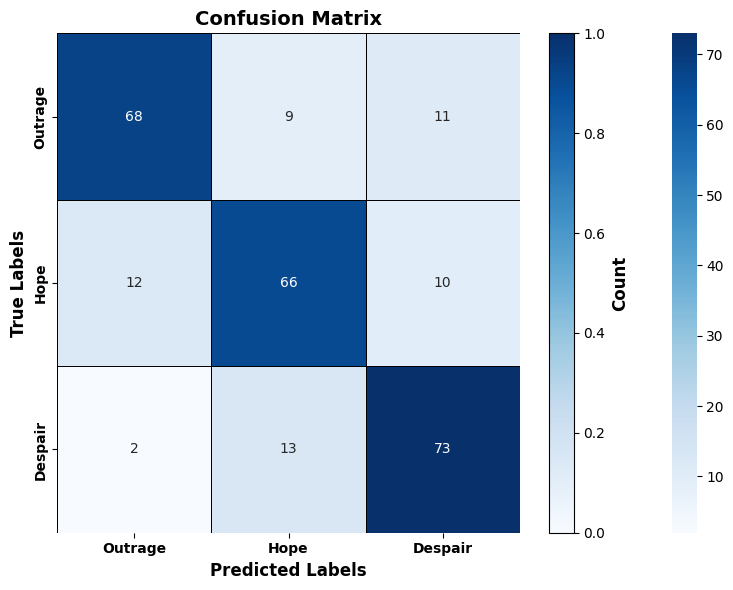

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace with your actual confusion matrix values
conf_matrix = confusion_matrix(test_labels, test_preds)

# Class names (adjust based on your dataset)
class_names = ['Outrage', 'Hope', 'Despair']

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))

# Define colormap and plot heatmap
sns.heatmap(
    conf_matrix,
    annot=True,             # Show cell values
    fmt='d',                # Format as integers
    cmap="Blues",           # Use the "Blues" colormap
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=0.5,         # Add gridlines for clarity
    linecolor='black'       # Color of the gridlines
)

# Add labels and title
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')

# Add a color bar with a label
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="Blues"))
cbar.set_label('Count', fontsize=12, fontweight='bold')

# Customize ticks on both axes for better readability
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the heatmap as a PDF or other file format
plt.savefig('confusion_matrix_classification.png')

# Display the plot
plt.show()
